# Topic Modeling using Theses' Abstracts
## 4. Data Preprocessing
Mai Vu<br>
Helsinki Metropolia University of Applied Sciences<br>
Bachelor’s Thesis<br>
May 2021

In [1]:
#Basic libraries
import random
import re
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from langdetect import detect
from langdetect import detect_langs
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
from itertools import chain

#Libraries for data visualization
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected = True)
init_notebook_mode(connected = True)

#Libraries for NLP
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### 4.2 Text Preparation and Word Clouds (cont.)

In [2]:
#Read data from pickle file
infile = open(r'final_data','rb')
df = pickle.load(infile)
infile.close()
df.reset_index()
print('Data length:', len(df))

#Count length of English and Finnish abstracts
df['en_fi_length'] = df['en'].str.split().str.len() + df['fi'].str.split().str.len()

df.sample(5)

Data length: 174955


,handle,year,original_language,organization,google_translated_en,en,google_translated_fi,fi,en_fi_length
100773,10024/108800,2016,sv,Arcada University of Applied Sciences,0,This thesis is a part of the Vaikuttavat Tavat...,0,Tämä opinnäytetyö on osa Vantaan kaupungin Vai...,505
47672,10024/60208,2013,fi,Haaga-Helia University of Applied Sciences,0,Ekotiimi is a team managing environmental resp...,0,Ekotiimi ylläpitää HAAGA-HELIA -ammattikorkeak...,516
120864,10024/122541,2017,fi,Oulu University of Applied Sciences,0,The subject of this thesis is researching the ...,0,"Opinnäytetyön aiheena on selvittää, millaisin ...",480
109382,10024/134455,2017,fi,Häme University of Applied Sciences,0,This Bachelor’s thesis dealt with an actualiza...,0,Tämä opinnäytetyö käsitteli lasten osallisuude...,362
118297,10024/123254,2017,fi,Häme University of Applied Sciences,0,Modular education first started in the degree ...,0,Hämeen ammattikorkeakoulussa rakennetun ympäri...,289


In [3]:
#Update stopwords dictionary, lemmatizer
eng_stopwords = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
lemmatizer = WordNetLemmatizer()

abb = []
bigrams = []
en_processed = []

for abstract in df['en']:
    tokens = []
    for token in nltk.word_tokenize(abstract):
        #If abbreviations: keep it
        if token.upper() == token and token.isalpha() and len(token) > 1:
            tokens.append(token)
            abb.append(token)
        #If normal words: if it does not in stopwords, length is greater than 3
        else:
            token = token.lower()
            if token.isalpha() and token not in eng_stopwords and len(token) > 3:
                tokens.append(lemmatizer.lemmatize(token)) #lemma the word
    en_processed.append(tokens)

#Apply bi-gram
bigram = gensim.models.Phrases(en_processed, min_count = 10, threshold = 10)
for idx in range(len(en_processed)):
    en_processed[idx] = bigram[en_processed[idx]]
    for token in en_processed[idx]:
        if "_" in token:
            bigrams.append(token)

df['en_processed'] = [' '.join(abstract) for abstract in en_processed]

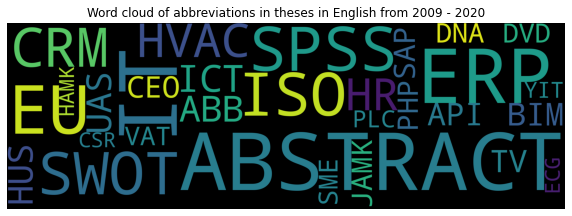

In [4]:
#Word cloud of abbreviations of theses in English from 2009 - 2020
wordcloud = WordCloud(width = 3000, height = 1000, 
                      max_words = 30, collocations = False, 
                      normalize_plurals = False, stopwords = "").generate(' '.join(abb))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title('Word cloud of abbreviations in theses in English from 2009 - 2020')
plt.axis("off")
#plt.savefig('AbbWordCloud.png')
plt.show()

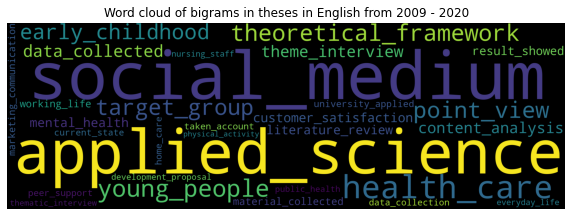

In [5]:
#Word cloud of bigrams in theses in English from 2009 - 2020
wordcloud = WordCloud(width = 3000, height = 1000, 
                      max_words = 30, collocations = False, 
                      normalize_plurals = False, stopwords = "").generate(' '.join(bigrams))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title('Word cloud of bigrams in theses in English from 2009 - 2020')
plt.axis("off")
#plt.savefig('BigramWordCloud.png')
plt.show()

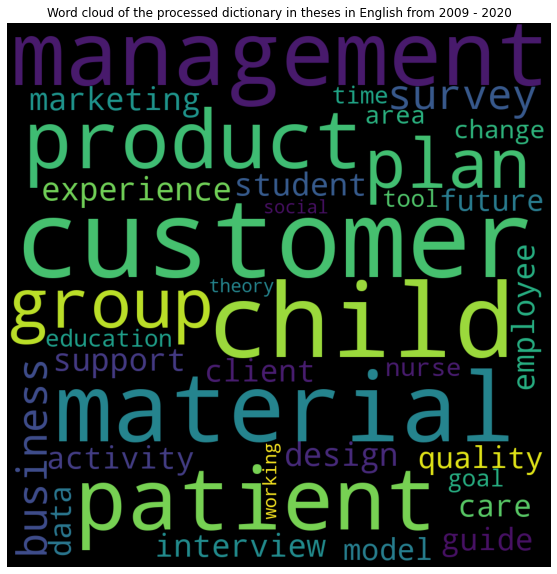

In [6]:
#Apply tf-idf
vectorizer = TfidfVectorizer(max_df = 0.25, min_df = 1000, lowercase = False)
response = vectorizer.fit_transform(df['en_processed'])
df_tfidf_sklearn = pd.DataFrame(response.toarray(), columns = vectorizer.get_feature_names())

#Word cloud of the processed dictionary in theses in English from 2009 - 2020
wordcloud = WordCloud(width = 1000, height = 1000, 
                      max_words = 35, collocations = False, 
                      normalize_plurals = False, stopwords = "").generate_from_frequencies(df_tfidf_sklearn.T.sum(axis = 1))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title('Word cloud of the processed dictionary in theses in English from 2009 - 2020')
plt.axis("off")
#plt.savefig('WordCloud2.png')
plt.show()